# testing foot stim protocol

In [25]:
df.head()

,time,camera,LED1,LED2,stim,button
0,0.00000,0.129435,-0.004598,0.295687,0.197740,-0.008464
1,0.00025,0.129435,-0.004598,0.369147,0.178408,-0.008464
2,0.00050,0.129435,-0.004598,0.403944,0.187430,-0.008464
3,0.00075,0.129435,-0.004598,0.420698,0.200317,-0.007175
4,0.00100,0.129435,-0.004598,0.429719,0.208050,-0.007175


<Axes: xlabel='time'>

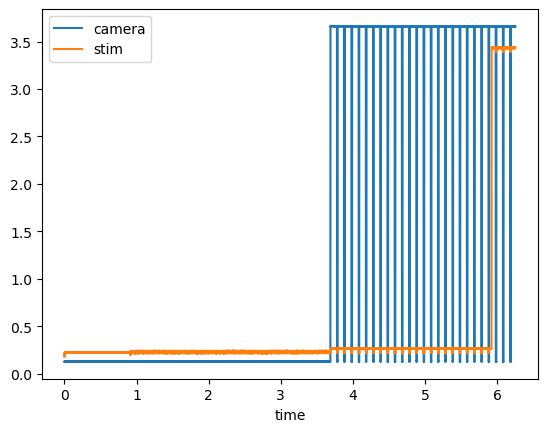

In [31]:
df[['camera', 'stim', 'time']].head(25000).plot(x='time')

In [22]:
from neuroprocessing.scripts.parse_csv import parse_csv
import pandas as pd

df = parse_csv('/Users/ilya_arcadia/arcadia-neuroimaging-pruritogens/Videos/2024-02-29/Zyla_5min_RHLstim_2son4soff_1pt25pctISO_1/Zyla_5min_RHLstim_2son4soff_1pt25pctISO_1.csv')



SyntaxError: invalid syntax (3733536226.py, line 5)

In [7]:
import numpy as np
import skimage.io as io
# genrate 3d array of random numbers
a = np.random.random((20,100,100))

# convert to uint8
a = (a*255).astype(np.uint8)

io.imsave('random.gif', a, duration=1, loop=0)

Loaded 1 trials.
Loaded 1 sync infos.
1
[11, 21, 41, 51, 71, 81, 101, 111, 131, 141, 161, 171, 191, 201, 221, 231, 251, 261, 281, 291, 311, 321, 341, 351, 371, 381, 401, 411, 431, 441, 461, 471, 491, 501, 521, 531, 551, 561, 581, 591, 611, 621, 641, 651, 671, 681, 701, 711, 731, 741, 761, 771, 791, 801, 821, 831, 851, 861, 881, 891, 911, 921, 941, 951, 971, 981, 1001, 1011, 1031, 1041, 1061, 1071, 1091, 1101, 1121, 1131, 1151, 1161, 1181, 1191, 1211, 1221, 1241, 1251, 1271, 1281, 1301, 1311, 1331, 1341, 1361, 1371, 1391, 1401, 1421, 1431, 1451, 1461, 1481, 1491]
Frame pre-stim: 10, Frame post-stim: 15


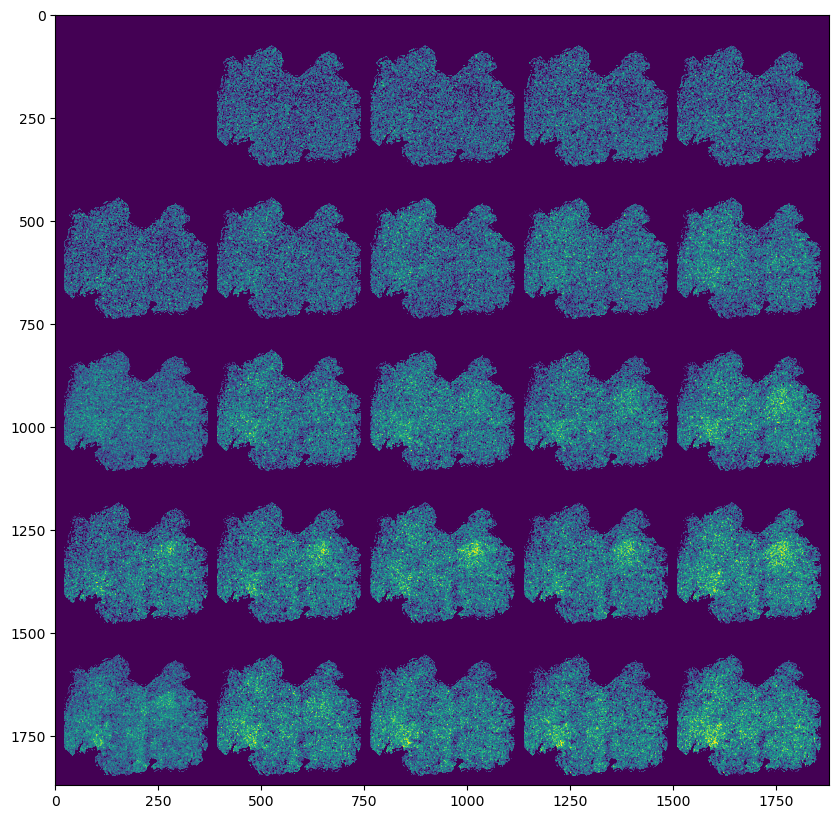

In [8]:
from neuroprocessing.imagingtrials import ImagingTrialLoader
import matplotlib.pyplot as plt
import numpy as np
from skimage import io
params = {
        "downsample_factor": 2,
        "secs_before_stim": 0, # only process frames starting at X seconds before stimulus
        "preprocess_prefix": "aligned_downsampled_",
        "process_prefix": 'processed_',
        "s3fs_toplvl_path": "/Users/ilya_arcadia/arcadia-neuroimaging-pruritogens/Videos",
        "local_toplvl_path": "/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/",
        "load_from_s3": False,
        "save_to_s3": False,
        'crop_px' : 20,
        'bottom_percentile' : 5
        }

trials = ImagingTrialLoader(params)
exp_dates, trial_names = trials.filter_exp_and_trial_dirs(exp_dir="2024-02-29",
                                                          limb='RHL',
                                                          rec_time='5min'
                                                        )

# f = trials.plot_montage(50,500,10, montage_hw=(7,30))
sta_list = trials.get_sta_stacks(2, 5)

from skimage.util import montage
for sta in sta_list:
        # plot mean intensity of image over time
        # ax.plot(sta[:,:,220:260,220:260].mean(axis=(2,3)).T)
        # ax[0].imshow(sta[:,15:,:,:].mean(axis=1).mean(axis=0))
        # ax[1].imshow(sta[:,:10,:,:].mean(axis=1).mean(axis=0))
        
        sta_mean = (sta - sta[:,0,:,:][:,np.newaxis,:,:]).mean(axis=0) # (sta - sta[:,0,:,:].mean(axis=0)).mean(axis=0)

        n_plots = sta_mean.shape[0]
        
        # fig, axs = plt.subplots(nrows = n_plots-1, figsize=(10,50))

        # for i in range(sta_mean.shape[0]-1):
        #         axs[i].imshow(sta_mean[i+1], cmap='viridis', vmin=30000,vmax=40000)
        #         axs[i].axis('off')

        f,ax = plt.subplots(1,1, figsize=(10,10))
        ax.imshow(montage(sta_mean, 
                                 fill = 0,
                                 padding_width = 20,
                                 rescale_intensity=False,
                                 grid_shape= None,
                                 # cmap='viridis',
                                 ),
                        cmap='viridis',
                        vmin=30000,
                        vmax=40000
                        )
        
        # color bar

        # plt.imshow(sta.mean(axis=0))
        # plt.show()

(array([4.1877e+04, 9.7000e+01, 5.6000e+01, 0.0000e+00, 5.4000e+01,
        4.2000e+01, 4.2000e+01, 0.0000e+00, 3.7000e+01, 1.8000e+01,
        0.0000e+00, 3.3000e+01, 3.1000e+01, 3.1000e+01, 0.0000e+00,
        2.7000e+01, 1.8000e+01, 0.0000e+00, 1.5000e+01, 2.2000e+01,
        2.6000e+01, 0.0000e+00, 2.4000e+01, 1.8000e+01, 1.0000e+00,
        2.3000e+01, 1.2000e+01, 2.1000e+01, 0.0000e+00, 1.9000e+01,
        1.6000e+01, 1.9000e+01, 3.0000e+00, 1.4000e+01, 1.8000e+01,
        0.0000e+00, 2.1000e+01, 1.7000e+01, 1.9000e+01, 0.0000e+00,
        2.3000e+01, 1.4000e+01, 0.0000e+00, 2.2000e+01, 3.7000e+01,
        4.0000e+01, 1.0000e+00, 5.5000e+01, 9.6000e+01, 0.0000e+00,
        1.4900e+02, 2.5200e+02, 3.9200e+02, 0.0000e+00, 5.3400e+02,
        8.4900e+02, 2.4000e+01, 1.1950e+03, 1.7150e+03, 2.2480e+03,
        0.0000e+00, 2.9630e+03, 3.6230e+03, 4.2970e+03, 9.8000e+01,
        5.0060e+03, 5.7100e+03, 0.0000e+00, 6.1250e+03, 6.3920e+03,
        6.1400e+03, 0.0000e+00, 5.9080e+03, 5.41

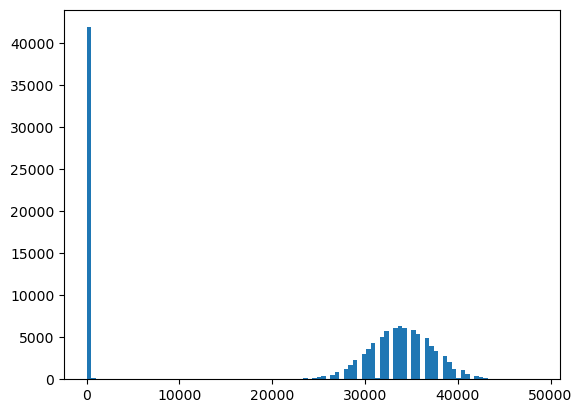

In [116]:
# histogram
plt.hist(sta_mean[-1,::].flatten(), bins=100)


In [85]:
sta[:,10:,:,:].mean(axis=1).shape

(97, 350, 352)

In [80]:
(sta[:,10:,:,:].mean(axis=1) - sta[:,6:,:,:].mean(axis=1)).mean(axis=0)

(97, 20)

In [1]:
#from neuroprocessing.scripts.parse_csv import parse_csv, process_data
from neuroprocessing.scripts.analysis import _get_sync_info
import pandas as pd

x = _get_sync_info('/Users/ilya_arcadia/arcadia-neuroimaging-pruritogens/Videos/2024-02-29/Zyla_5min_RHLstim_2son4soff_1pt25pctISO_1/Zyla_5min_RHLstim_2son4soff_1pt25pctISO_1.csv', 'stim')


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Stimulus onset frame: [  23   43   83  103  143  163  203  223  263  283  323  343  383  403
  443  463  503  523  563  583  623  643  683  703  743  763  803  823
  863  883  923  943  983 1003 1043 1063 1103 1123 1163 1183 1223 1243
 1283 1303 1343 1363 1403 1423 1463 1483 1523 1543 1583 1603 1643 1663
 1703 1723 1763 1783 1823 1843 1883 1903 1943 1963 2003 2023 2063 2083
 2123 2143 2183 2203 2243 2263 2303 2323 2363 2383 2423 2443 2483 2503
 2543 2563 2603 2623 2663 2683 2723 2743 2783 2803 2

In [1]:

# stim
# si = _get_sync_info('/Users/ilya_arcadia/Neuroimaging_local/Processed/Zyla_5min_LFL_2son4soff_1pt25pctISO_1.csv', 'stim')

# injection
# si = _get_sync_info('/Users/ilya_arcadia/Neuroimaging_local/Processed/Zyla_15min_LHL_50uLsalineinj_1pt5pctISO_1.csv', 'button')

from neuroprocessing.scripts.analysis import preprocess_and_process_trial, process_trial

params_stim = {
    "sync_csv_col": "stim",
    "downsample_factor": 2,
    "aligner_target_num_features": 700,
    "secs_before_stim": 0,
    "preprocess_prefix": "aligned_downsampled_",
    "process_prefix": "processed_",
    "s3fs_toplvl_path": "/Users/ilya_arcadia/arcadia-neuroimaging-pruritogens/Videos",
    "local_toplvl_path": "/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/",
    "load_from_s3": True,
    "save_to_s3": False,
    "crop_px": 20,
    "bottom_percentile": 5,
    "flood_connectivity": 20,
    "flood_tolerance" : 1000
}

params_inj = {
    "sync_csv_col": "button",
    "downsample_factor": 8,
    "aligner_target_num_features": 700,
    "secs_before_stim": 60,
    "preprocess_prefix": "aligned_downsampled_",
    "process_prefix": "processed_",
    "s3fs_toplvl_path": "/Users/ilya_arcadia/arcadia-neuroimaging-pruritogens/Videos",
    "local_toplvl_path": "/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/",
    "load_from_s3": True,
    "save_to_s3": False,
    "crop_px": 20,
    "bottom_percentile": 5,
    "flood_connectivity": 20,
    "flood_tolerance" : 1000
}
# preprocess_and_process_trial("2024-02-29", "Zyla_15min_LHL_salineinj_withpushbutton_1", params_inj)
preprocess_and_process_trial("2024-02-29", "Zyla_5min_RHLstim_2son4soff_1pt25pctISO_1", params_stim)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Loading raw stack from S3
Stimulus onset frame: [23, 43, 83, 103, 143, 163, 203, 223, 263, 283, 323, 343, 383, 403, 443, 463, 503, 523, 563, 583, 623, 643, 683, 703, 743, 763, 803, 823, 863, 883, 923, 943, 983, 1003, 1043, 1063, 1103, 1123, 1163, 1183, 1223, 1243, 1283, 1303, 1343, 1363, 1403, 1423, 1463, 1483, 1523, 1543, 1583, 1603, 1643, 1663, 1703, 1723, 1763, 1783, 1823, 1843, 1883, 1903, 1943, 1963, 2003, 2023, 2063, 2083, 2123, 2143, 2183, 2203, 2243, 2263, 2303, 2323, 2363, 2383, 2423, 2

 19%|█▉        | 282/1499 [00:00<00:03, 357.55it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


 25%|██▌       | 376/1499 [00:01<00:03, 330.94it/s]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


100%|██████████| 1499/1499 [08:42<00:00,  2.87it/s]


Loading raw stack from S3


/Users/ilya_arcadia/Code/arcadia-neuroimaging-pruritogens/src/neuroprocessing/scripts/analysis.py:219: UserWarning: /Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/2024-02-29/Zyla_5min_RHLstim_2son4soff_1pt25pctISO_1/processed_Zyla_5min_RHLstim_2son4soff_1pt25pctISO_1.tif is a low contrast image
  io.imsave(save_path / (params["process_prefix"] + trial_dir + '.tif'), stack)


In [23]:
stim_onset_frame = df_frames['stimulated'].diff().values
stim_onset_frame = np.where(stim_onset_frame == True)[0]

n_stims = len(stim_onset_frame)
print(f"Stimulus onset frame: {stim_onset_frame}")
print(f"Stimulus onset time (s): {df_frames.loc[stim_onset_frame, 'time'].values}")
stim_duration_frames = sum(df_frames['stimulated'])
frame_time_s = df_frames.loc[stim_onset_frame, 'frametime'].mean()
framerate_hz = 1/frame_time_s

sync_info = {
    "Number of stimulations": n_stims,
    "stim_onset_frame": stim_onset_frame,
    "stim_duration_frames": stim_duration_frames,
    "frame_time_s": frame_time_s,
    "framerate_hz": framerate_hz
}
print(f"Number of stimulations: {n_stims}")
print(f"Stimulus duration (overall) (frames): {stim_duration_frames}")
print(f"Stimulus duration (overall) (s): {stim_duration_frames/framerate_hz}")
print(f"Frame duration (ms): {frame_time_s*1000}")
print(f"Framerate (Hz): %.2f" % (framerate_hz))


Stimulus onset frame: [  33   53   93  113  153  173  213  233  273  293  333  353  393  413
  453  473  513  533  573  593  633  653  693  713  753  773  813  833
  873  893  933  953  993 1013 1053 1073 1113 1133 1173 1193 1233 1253
 1293 1313 1353 1373 1413 1433 1473 1493 1533 1553 1593 1613 1653 1673
 1713 1733 1773 1793 1833 1853 1893 1913 1953 1973 2013 2033 2073 2093
 2133 2153 2193 2213 2253 2273 2313 2333 2373 2393 2433 2453 2493 2513
 2553 2573 2613 2633 2673 2693 2733 2753 2793 2813 2853 2873 2913 2933
 2973 2993]
Stimulus onset time (s): [  6.996     8.99625  12.99625  14.9965   18.9965   20.9965   24.99675
  26.99675  30.997    32.997    36.99725  38.99725  42.9975   44.9975
  48.9975   50.99775  54.99775  56.998    60.998    62.99825  66.99825
  68.99825  72.9985   74.9985   78.99875  80.99875  84.999    86.999
  90.99925  92.99925  96.99925  98.9995  102.9995  104.99975 108.99975
 111.      115.      117.      121.00025 123.00025 127.0005  129.0005
 133.00075 135.00075 1

In [11]:
import numpy as np
# find frames every time the stimulated column changes to true
stim_onsets = df_frames['stimulated'].diff().values
stim_onsets = np.where(stim_onsets == True)[0]

# df_frames['stimulated'].apply(lambda x: np.where(x==True)[0][0],axis=1)


# Analyze whole-brain activity
* Uses `ImagingTrialLoader` to load data

In [ ]:
from neuroprocessing.imagingtrials import ImagingTrialLoader
import matplotlib.pyplot as plt
import numpy as np
params = {
        "downsample_factor": 8,
        "aligner_target_num_features": 700,
        "secs_before_stim": 60, # only process frames starting at X seconds before stimulus
        "preprocess_prefix": "aligned_downsampled_",
        "process_prefix": 'processed_',
        "s3fs_toplvl_path": "/Users/ilya_arcadia/arcadia-neuroimaging-pruritogens/Videos",
        "local_toplvl_path": "/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/",
        "load_from_s3": False,
        "save_to_s3": False,
        'crop_px' : 20,
        'bottom_percentile' : 5
        }

trials = ImagingTrialLoader(params)
exp_dates, trial_names = trials.filter_exp_and_trial_dirs(exp_dir="2024-03-20-F1Num8REP",
                                                          limb='RHL'
                                                        )
# exp_dates, trial_names = trials.filter_exp_and_trial_dirs()

masks = trials.load_mask_files()
traces = trials.load_traces()
sync_infos = trials.get_sync_infos()
# Plot the traces

fig, ax = plt.subplots(figsize=(5,3))
for trace, exp_date, trial_name, sync in zip(traces, exp_dates, trial_names, sync_infos):
    t = (np.arange(0, len(trace))) / (sync['framerate_hz'] / params['downsample_factor']) - params['secs_before_stim']
    trace = trace - trace[np.where(t >= 0)[0][0]]
    # remove slope
    trace = trace - np.polyval(np.polyfit(t, trace, 1), t)
    ax.plot(t, trace, label=exp_date + ' ' + trial_name)
# legend to the right of the plot
# ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.axvline(x=0, color='r', linestyle='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Response (a.u.)')
ax.set_xlim([-50, 600])
# plot masks
fig, axs = plt.subplots(ncols=len(masks), figsize=(15, 7))
for ax, mask, exp_date, trial_name in zip(axs, masks, exp_dates, trial_names):
    ax.imshow(mask, cmap='gray')
    # remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(exp_date + ' ' + trial_name, fontsize=8)
plt.tight_layout()


# SVD and alignment to AI CCF

In [ ]:
from wfield import load_stack, approximate_svd, chunk_indices, SVDStack, load_allen_landmarks, allen_load_reference, allen_transform_regions, atlas_from_landmarks_file
from skimage import io
from neuroprocessing.scripts.analysis import _identify_trial_save_paths
import numpy as np
import os, sys, glob

def _run_SVD(img_stack, n_SVD_components = 200):
    """ Wrapper for wfield's SVD function"""

    chunkidx = chunk_indices(len(img_stack),chunksize=256)
    _frame_averages = []
    for on,off in chunkidx:
        _frame_averages.append(img_stack[on:off].mean(axis=0))

    _frames_average = np.stack(_frame_averages).mean(axis = 0)
    U,SVT = approximate_svd(img_stack, _frames_average, 
                            k = n_SVD_components,
                            nframes_per_bin=10)
    return _frames_average, U,SVT

def _reconstruct(u,svt,dims = None):
    """Reconstruct the movie from the SVD components."""
    if dims is None:
            dims = u.shape[:2]
    return (u@svt).reshape((*dims,-1)).transpose(-1,0,1).squeeze()


def run_SVD_and_alignment(exp_dir, trial_dir, params):
    trial_path, save_path = _identify_trial_save_paths(exp_dir, trial_dir, params)
    dat = load_stack(save_path / (params["preprocess_prefix"] + trial_dir + ".tif"))

    frames_average, U,SVT = _run_SVD(dat, n_SVD_components = 2)

    # reconstructed movie
    mov = _reconstruct(U,SVT).reshape(dat.nframes,1,*U.shape[:2])
    mov = (mov*frames_average)+frames_average
    # save SVD
    np.save(save_path / ('U_' + params["process_prefix"] + trial_dir + '.npy'), U)
    np.save(save_path / ('SVT_' + params["process_prefix"] + trial_dir + '.npy'), SVT)
    np.save(save_path / ('frames_average_' + params["process_prefix"] + trial_dir + '.npy'), frames_average)
    io.imsave(save_path / ('svd_' + params["process_prefix"] + trial_dir + '.tif'), mov.squeeze().astype(np.uint16))

    from wfield.widgets import QApplication,RawViewer
    app_args = ['/Users/ilya_arcadia/miniconda3/envs/neuro/bin/wfield', 'open_raw', trial_path]
    app = QApplication(app_args)
    w = RawViewer(raw = dat,
                    mask = None,
                    folder = trial_path,
                    trial_onsets = None,
                    reference = 'dorsal_cortex')
    # close app
    app.exec_()
    
    del dat

    # AI CCF alignment
    
    landmarks_json = os.path.join(trial_path,'dorsal_cortex_landmarks.json')
    U = np.load(glob.glob(os.path.join(trial_path, 'U_*.npy'))[0])
    SVT = np.load(glob.glob(os.path.join(trial_path, 'SVT_*.npy'))[0])

    stack = SVDStack(U,SVT)
    lmarks = load_allen_landmarks(os.path.join(trial_path,'dorsal_cortex_landmarks.json'))

    ccf_regions_reference,proj,brain_outline = allen_load_reference('dorsal_cortex')
    # the reference is in allen CCF space and needs to be converted
    # this converts to warped image space (accounting for the transformation)
    ccf_regions = allen_transform_regions(None,ccf_regions_reference,
                                        resolution = lmarks['resolution'],
                                            bregma_offset = lmarks['bregma_offset'])
    atlas, areanames, brain_mask = atlas_from_landmarks_file(landmarks_json) # this loads the atlas in transformed coords

    # this does the transform (warps the original images)
    # stack.set_warped(1, M = lmarks['transform']) # this warps the spatial components in the stack
    stack.set_warped(False)
    return ccf_regions

params = {
        "downsample_factor": 8,
        "aligner_target_num_features": 700,
        "secs_before_stim": 60, # only process frames starting at X seconds before stimulus
        "preprocess_prefix": "aligned_downsampled_",
        "process_prefix": 'processed_',
        "s3fs_toplvl_path": "/Users/ilya_arcadia/arcadia-neuroimaging-pruritogens/Videos",
        "local_toplvl_path": '/Users/ilya_arcadia/Neuroimaging_local/Processed/wfield_testing', # "/Users/ilya_arcadia/Neuroimaging_local/Processed/Injections/",
        "load_from_s3": False,
        "save_to_s3": False,
        'crop_px' : 20,
        'bottom_percentile' : 5
        }

ccf = run_SVD_and_alignment('2024-03-20-F1Num8REP', 'Zyla_15min_RHL_salineInj_1pt5pctISO_1', params=params)


# Generate dorsal mask png using wfield

In [ ]:
import matplotlib.pyplot as plt

def plot_allen_regions(ax, ccf_regions,
                          resolution = 1,
                          bregma_offset = np.array([0,0]),
                          side_selection='both'):
    '''
    Plot the Allen CCF regions on a matplotlib axis.
    '''

    regs = []
    for p in ccf_regions.iterrows():
        c = p[1]
        if side_selection in ['right','both']:
            ax.plot(np.array(c.right_x)/resolution + bregma_offset[0],
                    np.array(c.right_y)/resolution + bregma_offset[1], 'w')
            # regs.append(hv.Curve(np.vstack([np.array(c.right_x)/resolution + bregma_offset[0],
            #                                 np.array(c.right_y)/resolution + bregma_offset[1]]).T))
        if side_selection in ['left','both']:
            ax.plot(np.array(c.left_x)/resolution + bregma_offset[0],
                    np.array(c.left_y)/resolution + bregma_offset[1], 'w')
            # regs.append(hv.Curve(np.vstack([np.array(c.left_x)/resolution + bregma_offset[0],
            #                                 np.array(c.left_y)/resolution + bregma_offset[1]]).T))
    # invert y axis
    return ax

img = io.imread('/Users/ilya_arcadia/Neuroimaging_local/Processed/wfield_testing/2024-03-20-F1Num8REP/Zyla_15min_RHL_salineInj_1pt5pctISO_1/aligned_downsampled_Zyla_15min_RHL_salineInj_1pt5pctISO_1.tif')
img_max = img.max(axis=0)
del img
f, ax = plt.subplots()
# ax.imshow(img_max, cmap='gray')
plot_allen_regions(ax, ccf, resolution = 1, bregma_offset = np.array([0,0]), side_selection='both')
ax.set_axis_off()
f.savefig('test.png')

# Quick script to calculate FFT of signal

In [ ]:
## FFT of the ROI
import numpy as np
import matplotlib.pyplot as plt
# get roi at center of image
center = np.array(img.shape) // 2
roi = img[:,center[1]-50:center[1]+50, center[2]-50:center[2]+50]
roi_mean = np.mean(roi, axis=(1,2))
# calculate heart rate using FFT
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq

fs = 10 # Hz
t_orig = np.arange(0, len(roi_mean)) / fs
roi_mean = roi_mean - np.mean(roi_mean)
N = len(roi_mean)
yf = fft(roi_mean)
yf = 2.0/N * np.abs(yf[0:N//2])

xf = fftfreq(N, 1/fs)[:N//2]
f, axs = plt.subplots(2, 1)
axs[0].plot(roi_mean)
axs[0].set_xlim(0, 200)
axs[1].plot(xf, yf)
plt.xlim(0.5,3)
plt.ylim(0, 3)

# find peaks
peaks, _ = find_peaks(yf, height=5, distance=10)
plt.plot(xf[peaks], yf[peaks], "x")

# Spectrogram figure

In [ ]:
from scipy import ndimage
from scipy.signal import spectrogram
from scipy.interpolate import CubicSpline
import skimage.io as io
from scipy.signal import find_peaks

def compute_breathing_rate(signal: np.array, fs:float) -> np.array:
    """Compute breathing rate from signal using spectrogram.
    Args:
        signal (np.ndarray): 1D array of signal
        fs (float): sampling frequency
    
    Returns:
        np.array: 1D numpy array of breathing rate, interpolated to be the same length as signal
    """

    min_peak_height = 100 # minimum height of freq peak in spectrogram
    min_breathing_freq, max_breathing_freq = 0.5, 2 # frequency range to look for breathing rate (Hz)
    spectrogram_nperseg = 200 # number of samples per segment in spectrogram
    spectrogram_noverlap = 50 # number of samples to overlap between segments in spectrogram


    f, t, Sxx = spectrogram(signal, fs, nperseg=spectrogram_nperseg, noverlap=spectrogram_noverlap, detrend = 'linear')
    plt.pcolormesh(t, f, Sxx, shading='gouraud')
    plt.ylim(0, 3)


    breathing_freqs = (f > min_breathing_freq) & (f < max_breathing_freq)
    Sxx_breathing = Sxx[breathing_freqs]

    # find peaks in spectrogram
    f_peak_array = []
    for i in range(Sxx_breathing.shape[1]):
        peaks, _ = find_peaks(Sxx_breathing[:,i], height=min_peak_height, distance=4)
        # if >1 peak, keep only highest
        if len(peaks) > 0:
            peaks = [peaks[np.argmax(Sxx_breathing[peaks, i])]]
            f_peak = f[breathing_freqs][peaks]
            f_peak_array.append(f_peak[0])
        else:
            f_peak_array.append(np.nan)

    f_peak_array = np.array(f_peak_array)

    # remove nans
    t_peak_array = t[~np.isnan(f_peak_array)]
    f_peak_array = f_peak_array[~np.isnan(f_peak_array)]
    # plt.plot(t_peak_array,f_peak_array)

    # interpolate back to be the same size as roi_mean
    f_peak_interp = CubicSpline(t_peak_array, f_peak_array, bc_type='natural')

    return f_peak_interp(np.arange(0, len(signal)) / fs)

if 'img' not in locals():
    img = io.imread('/Users/ilya_arcadia/arcadia-neuroimaging-pruritogens/Videos/2024-03-06/Zyla_15min_RHL_salineinj_1pt25pctISO_1/Zyla_15min_RHL_salineinj_1pt25pctISO_1_MMStack_Pos0.ome.tif')
center = np.array(img.shape) // 2
roi = img[:,center[1]-50:center[1]+50, center[2]-50:center[2]+50]
roi_mean = np.mean(roi, axis=(1,2))
f_breathing = compute_breathing_rate(roi_mean, fs = 10)
# f,ax = plt.subplots()
# plt.plot(f_breathing)

# Plot of FOV vs resolution for different microscopes at Arcadia

In [ ]:
import matplotlib.pyplot as plt
fovs = [13.7, 1, 10880, 151]
res = [615, 2300, 11, 190]
labels = ['Hina 4x', 'Hina 10x', 'Phenotypomat', 'UWFM']
f,ax = plt.subplots(figsize=(3,3))
plt.loglog(fovs,res, 'o')
plt.ylabel('Resolution (px/mm)')
plt.xlabel(r'Field of view $(mm{^2})$')
# add labels
for i, txt in enumerate(labels):
    if txt.startswith('Phe'):
        ax.annotate(txt, (fovs[i], res[i]), textcoords="offset points", xytext=(-5,0), va='center', ha='right')
    else:
        ax.annotate(txt, (fovs[i], res[i]), textcoords="offset points", xytext=(10,0), va='center')
